In [28]:
!pip install transformers
# !pip install sentencepiece

In [29]:
import pandas as pd
import torch
import transformers
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, AutoTokenizer, BertModel, BertConfig, AutoModel, AdamW, AlbertTokenizer, AlbertConfig, AlbertModel
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import random
from torch.optim.lr_scheduler import ExponentialLR, MultiStepLR

In [30]:
# data = pd.read_csv('bbc-news-data.csv', sep='\t')
data = pd.read_json('/kaggle/input/data-coursework/News_Category_Dataset_v3.json', lines=True)
data.head(2)

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23


In [31]:
data['content'] = data.headline + ' ' + data.short_description
labels = data.category

In [32]:
data.drop(['authors','link','date', 'headline', 'short_description'], axis=1, inplace=True)

In [33]:
text = data.content
labels = data.category

In [34]:
labels.unique()

array(['U.S. NEWS', 'COMEDY', 'PARENTING', 'WORLD NEWS', 'CULTURE & ARTS',
       'TECH', 'SPORTS', 'ENTERTAINMENT', 'POLITICS', 'WEIRD NEWS',
       'ENVIRONMENT', 'EDUCATION', 'CRIME', 'SCIENCE', 'WELLNESS',
       'BUSINESS', 'STYLE & BEAUTY', 'FOOD & DRINK', 'MEDIA',
       'QUEER VOICES', 'HOME & LIVING', 'WOMEN', 'BLACK VOICES', 'TRAVEL',
       'MONEY', 'RELIGION', 'LATINO VOICES', 'IMPACT', 'WEDDINGS',
       'COLLEGE', 'PARENTS', 'ARTS & CULTURE', 'STYLE', 'GREEN', 'TASTE',
       'HEALTHY LIVING', 'THE WORLDPOST', 'GOOD NEWS', 'WORLDPOST',
       'FIFTY', 'ARTS', 'DIVORCE'], dtype=object)

In [35]:
train_inputs, test_inputs, train_labels, test_labels = train_test_split(text, labels,
random_state=42,test_size=0.20, stratify=labels)

In [36]:
# test_inputs, validation_inputs, test_labels, validation_labels = train_test_split(test_inputs, test_labels,
# random_state=42,test_size=0.50, stratify=test_labels)

In [37]:
train = pd.concat([train_inputs, train_labels], sort=False, axis=1)
test = pd.concat([test_inputs, test_labels], sort=False, axis=1)

In [38]:
for i in ['U.S. NEWS', 'COMEDY', 'PARENTING', 'WORLD NEWS', 'CULTURE & ARTS',
       'TECH', 'SPORTS', 'ENTERTAINMENT', 'POLITICS', 'WEIRD NEWS',
       'ENVIRONMENT', 'EDUCATION', 'CRIME', 'SCIENCE', 'WELLNESS',
       'BUSINESS', 'STYLE & BEAUTY', 'FOOD & DRINK', 'MEDIA',
       'QUEER VOICES', 'HOME & LIVING', 'WOMEN', 'BLACK VOICES', 'TRAVEL',
       'MONEY', 'RELIGION', 'LATINO VOICES', 'IMPACT', 'WEDDINGS',
       'COLLEGE', 'PARENTS', 'ARTS & CULTURE', 'STYLE', 'GREEN', 'TASTE',
       'HEALTHY LIVING', 'THE WORLDPOST', 'GOOD NEWS', 'WORLDPOST',
       'FIFTY', 'ARTS', 'DIVORCE']:
    train[i] = train['category'].apply(lambda x: 1 if i in x else 0)
    test[i] = test['category'].apply(lambda x: 1 if i in x else 0)

In [39]:
train.drop(['category'], axis=1, inplace=True)
test.drop(['category'], axis=1, inplace=True)
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

In [40]:
train.head(2)

,content,U.S. NEWS,COMEDY,PARENTING,WORLD NEWS,CULTURE & ARTS,TECH,SPORTS,ENTERTAINMENT,POLITICS,...,STYLE,GREEN,TASTE,HEALTHY LIVING,THE WORLDPOST,GOOD NEWS,WORLDPOST,FIFTY,ARTS,DIVORCE
0,The Last Letter: Coming Out To My Late Father ...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"In Fatal Shootings By Police, 1 In 5 Officers'...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [41]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [42]:
MAX_LEN = 128
TRAIN_BATCH_SIZE = 64
VALID_BATCH_SIZE = 64
EPOCHS = 3
LEARNING_RATE = 2e-5
# tokenizer = AutoTokenizer.from_pretrained('roberta-base')
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

In [43]:
target_cols = [col for col in train.columns if col not in ['content']]
target_cols

['U.S. NEWS',
 'COMEDY',
 'PARENTING',
 'WORLD NEWS',
 'CULTURE & ARTS',
 'TECH',
 'SPORTS',
 'ENTERTAINMENT',
 'POLITICS',
 'WEIRD NEWS',
 'ENVIRONMENT',
 'EDUCATION',
 'CRIME',
 'SCIENCE',
 'WELLNESS',
 'BUSINESS',
 'STYLE & BEAUTY',
 'FOOD & DRINK',
 'MEDIA',
 'QUEER VOICES',
 'HOME & LIVING',
 'WOMEN',
 'BLACK VOICES',
 'TRAVEL',
 'MONEY',
 'RELIGION',
 'LATINO VOICES',
 'IMPACT',
 'WEDDINGS',
 'COLLEGE',
 'PARENTS',
 'ARTS & CULTURE',
 'STYLE',
 'GREEN',
 'TASTE',
 'HEALTHY LIVING',
 'THE WORLDPOST',
 'GOOD NEWS',
 'WORLDPOST',
 'FIFTY',
 'ARTS',
 'DIVORCE']

In [44]:
len(target_cols)

42

In [45]:
class BERTDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.df = df
        self.max_len = max_len
        self.text = df.content
        self.tokenizer = tokenizer
        self.targets = df[target_cols].values

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
            text,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [46]:
train_dataset = BERTDataset(train, tokenizer, MAX_LEN)
test_dataset = BERTDataset(test, tokenizer, MAX_LEN)

In [47]:
train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE,
                          num_workers=2, shuffle=True)#, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=VALID_BATCH_SIZE,
                          num_workers=2, shuffle=False)#, pin_memory=True)

In [50]:
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        # self.roberta = AutoModel.from_pretrained('xlm-roberta-base')
        # self.roberta = AutoModel.from_pretrained('roberta-base')
        # self.bert = AutoModel.from_pretrained('bert-base-uncased')
        self.bert = AutoModel.from_pretrained('bert-base-uncased')
        # self.albert = AlbertModel.from_pretrained('')
        # self.l2 = torch.nn.Dropout(0.3)
        self.fc = torch.nn.Linear(768, 42)

    def forward(self, ids, mask, token_type_ids):
        _, features = self.bert(ids, attention_mask = mask, token_type_ids = token_type_ids, return_dict=False)
        # _, features = self.albert(ids, attention_mask = mask, token_type_ids = token_type_ids, return_dict=False)
#         output_2 = self.l2(output_1)
        output = self.fc(features)
        return output

model = BERTClass()
model.to(device);

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [51]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)
optimizer = AdamW(params =  model.parameters(), lr=LEARNING_RATE, weight_decay=1e-6)
scheduler1 = ExponentialLR(optimizer, gamma=0.9)
scheduler2 = MultiStepLR(optimizer, milestones=[30,80], gamma=0.1)

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [52]:
def train(epoch):
    model.train()
    for _,data in enumerate(train_loader, 0):
      # print(data)
      ids = data['ids'].to(device, dtype = torch.long)
      mask = data['mask'].to(device, dtype = torch.long)
      token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
      targets = data['targets'].to(device, dtype = torch.float)

      outputs = model(ids, mask, token_type_ids)

      loss = loss_fn(outputs, targets)
      if _%1500 == 0:
          print(f'Epoch: {epoch}, Loss:  {loss.item()}')

      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

1. MAX_LEN = 128
TRAIN_BATCH_SIZE = 64
EPOCHS = 3
LEARNING_RATE = 2e-5 
bert-base-uncased

In [53]:
for epoch in range(EPOCHS):
  train(epoch)

Epoch: 0, Loss:  0.7145724296569824
Epoch: 0, Loss:  0.06890325248241425
Epoch: 1, Loss:  0.04754108190536499
Epoch: 1, Loss:  0.049471672624349594
Epoch: 2, Loss:  0.03854925185441971
Epoch: 2, Loss:  0.05453307926654816


KeyboardInterrupt: 

2. MAX_LEN = 128
TRAIN_BATCH_SIZE = 32
EPOCHS = 2
LEARNING_RATE = 2e-5

In [ ]:
for epoch in range(EPOCHS):
  train(epoch)

3. MAX_LEN = 128
TRAIN_BATCH_SIZE = 64
EPOCHS = 2
LEARNING_RATE = 2e-5
bert-large-uncased

In [47]:
for epoch in range(EPOCHS):
  train(epoch)

OutOfMemoryError: ignored

In [55]:
def test():
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for _, data in enumerate(test_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets

1. MAX_LEN = 128
TRAIN_BATCH_SIZE = 64
EPOCHS = 2
LEARNING_RATE = 2e-5

In [ ]:
# bert
# MAX_LEN = 128
# TRAIN_BATCH_SIZE = 64
# VALID_BATCH_SIZE = 64
# EPOCHS = 2
# LEARNING_RATE = 2e-5
outputs, targets = test()
outputs = np.array(outputs) >= 0.5
accuracy = metrics.accuracy_score(targets, outputs)
f1_score_micro = metrics.f1_score(targets, outputs, average='micro')
f1_score_macro = metrics.f1_score(targets, outputs, average='macro')
f1_score_weighted = metrics.f1_score(targets, outputs, average='weighted')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")
print(f"F1 Score (Weighted) = {f1_score_weighted}")

Accuracy Score = 0.654035221686632

F1 Score (Micro) = 0.7180192246150928

F1 Score (Macro) = 0.5952840033341497

F1 Score (Weighted) = 0.7020280991660581


2. MAX_LEN = 128
TRAIN_BATCH_SIZE = 32
EPOCHS = 3
LEARNING_RATE = 2e-5

In [57]:
outputs, targets = test()
outputs = np.array(outputs) >= 0.5
accuracy = metrics.accuracy_score(targets, outputs)
f1_score_micro = metrics.f1_score(targets, outputs, average='micro')
f1_score_macro = metrics.f1_score(targets, outputs, average='macro')
f1_score_weighted = metrics.f1_score(targets, outputs, average='weighted')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")
print(f"F1 Score (Weighted) = {f1_score_weighted}")

Accuracy Score = 0.6428196439650646
F1 Score (Micro) = 0.7096704484062669
F1 Score (Macro) = 0.5837492708300702
F1 Score (Weighted) = 0.6942137816713685


In [ ]:
def confusion_m():
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for _, data in enumerate(test_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets

In [ ]:
outputs, targets = test()

In [ ]:
new_targets = []
for each in targets:
  tar = []
  for i in range(1, 43, 1):
    # print(each[i] * i)
    tar.append(int(each[i - 1] * (i)))
  new_targets.append(max(tar))

In [ ]:
new_outputs = []
for each in outputs:
  tar = []
  for i in range(1, 43, 1):
    # print(each[i] * i)
    tar.append(int(each[i - 1] * (i)))
  if (max(tar)==0):
    new_outputs.append(random.randint(1, 43))
  else:
    new_outputs.append(max(tar))

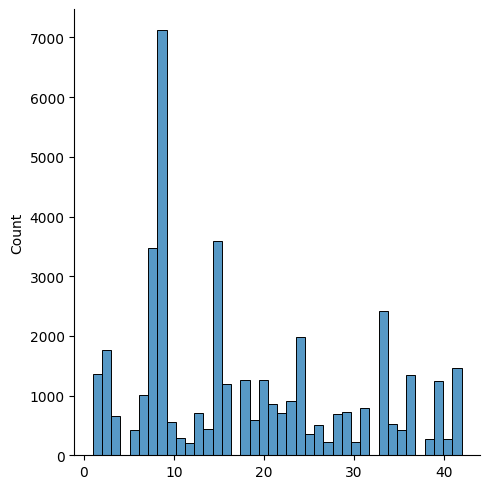

In [ ]:
sns.displot(new_targets)

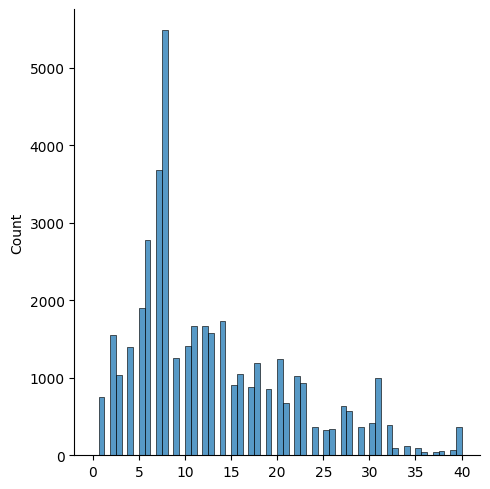

In [ ]:
sns.displot(new_outputs)

Text(0.5, 1.0, 'CONFUSION MATRIX RoBERTa\n')

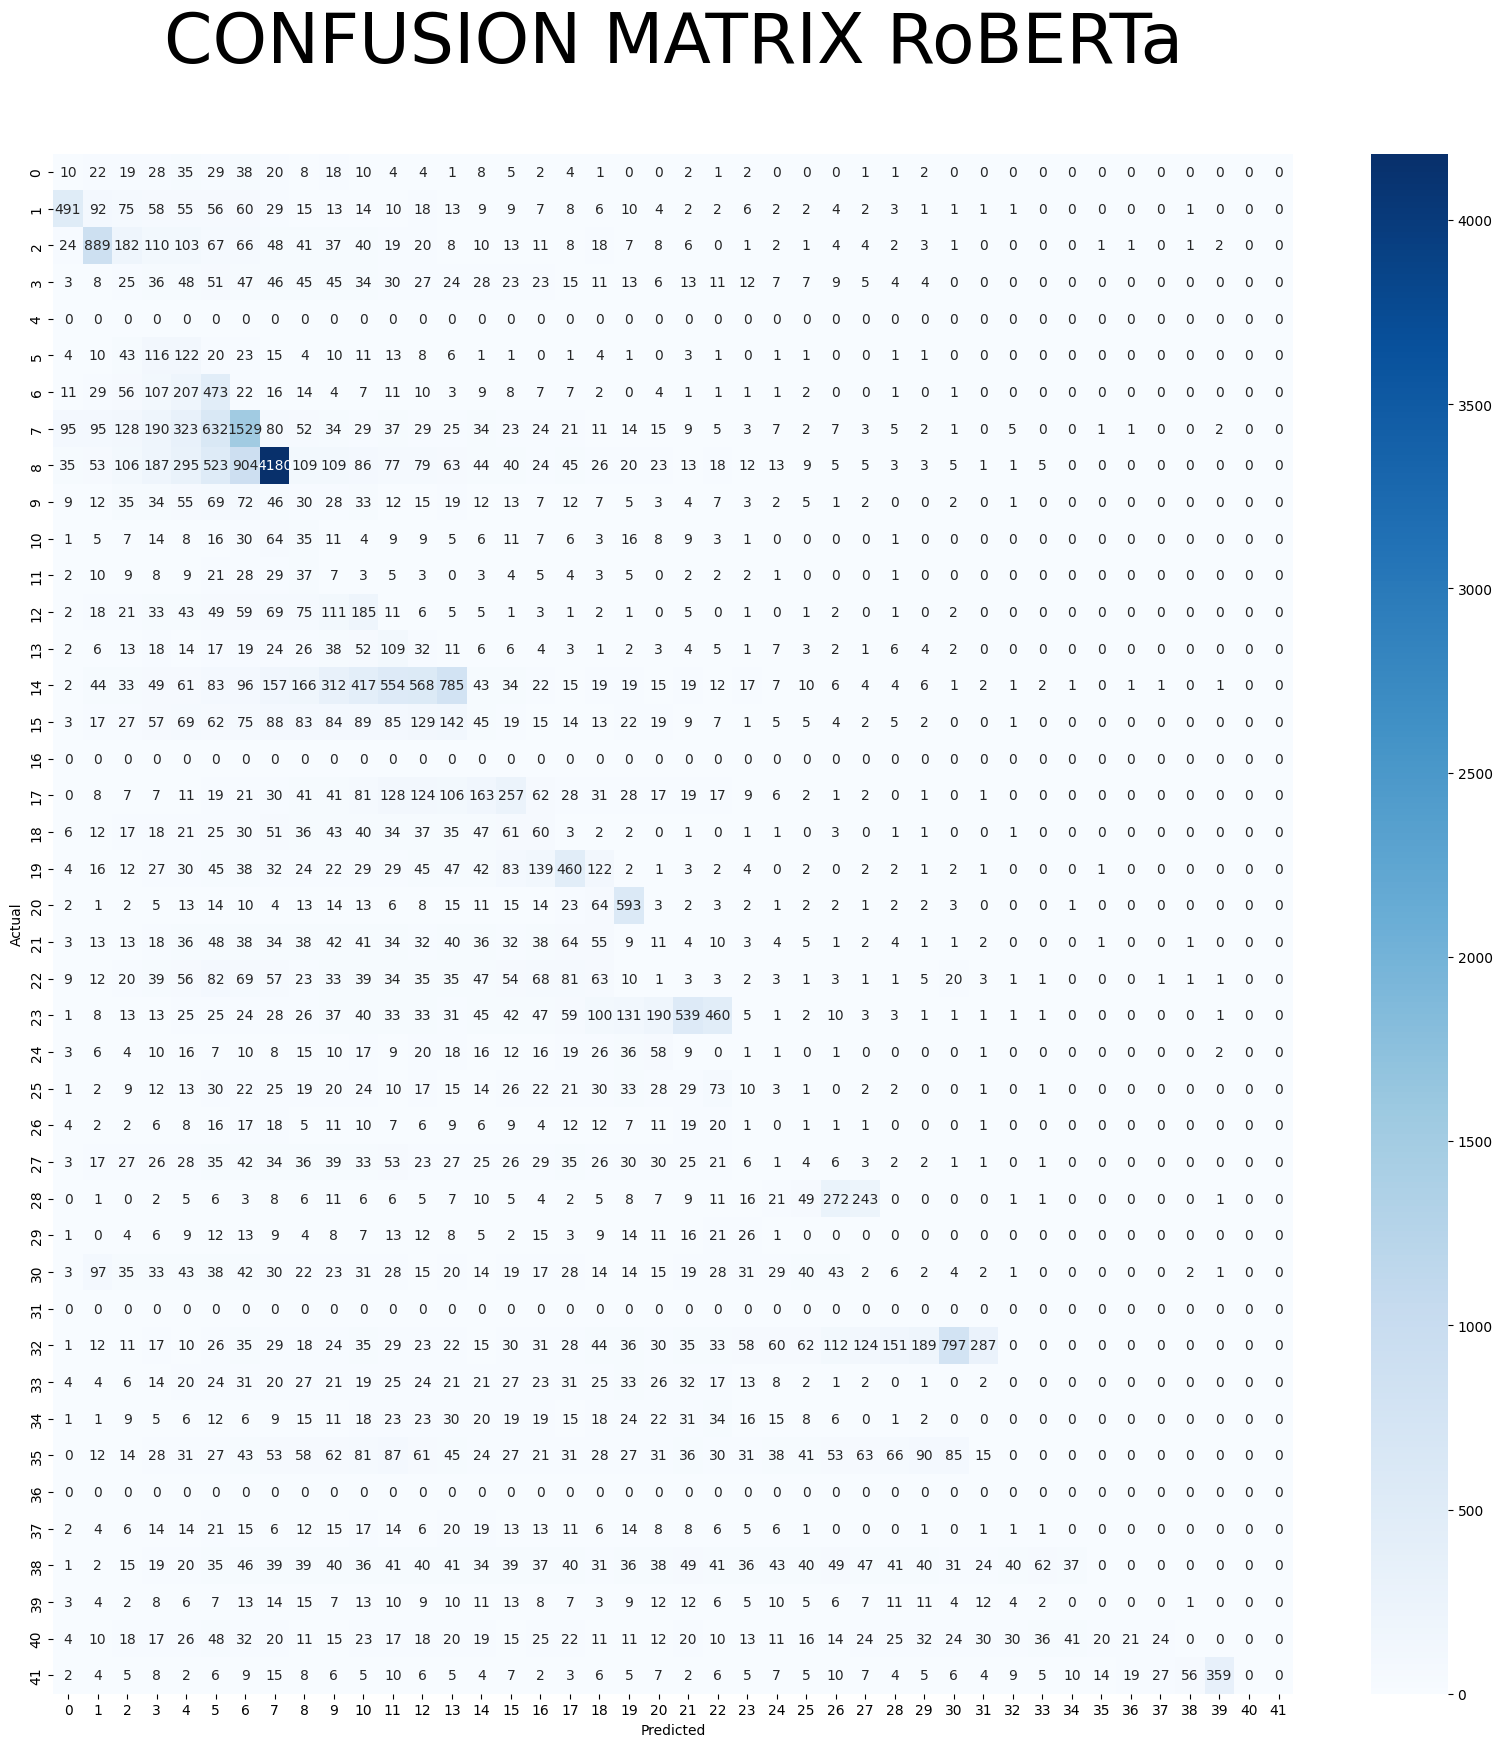

In [ ]:
# MAX_LEN = 128
# TRAIN_BATCH_SIZE = 32
# VALID_BATCH_SIZE = 32
# EPOCHS = 3
# LEARNING_RATE = 2e-5
conf_mat = metrics.confusion_matrix(new_targets, new_outputs)
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX RoBERTa\n", size=50)

In [58]:
def test_model_by_train():
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for _, data in enumerate(train_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets

In [59]:
train_outputs, train_targets = test_model_by_train()
train_outputs = np.array(train_outputs) >= 0.5
accuracy = metrics.accuracy_score(train_targets, train_outputs)
f1_score_micro = metrics.f1_score(train_targets, train_outputs, average='micro')
f1_score_macro = metrics.f1_score(train_targets, train_outputs, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

Accuracy Score = 0.7531156597323725
F1 Score (Micro) = 0.8160942885821685
F1 Score (Macro) = 0.7087901389752197


In [60]:
train_outputs, train_targets = test_model_by_train()

In [61]:
new_targets = []
for each in train_targets:
  tar = []
  for i in range(0, 42, 1):
    # print(each[i] * i)
    tar.append(int(each[i] * (i)))
  new_targets.append(max(tar))

In [62]:
from sklearn.svm import LinearSVC

In [64]:
test_outputs, test_targets = test()

In [66]:
test_labels = []
for each in test_targets:
  tar = []
  for i in range(0, 42, 1):
    # print(each[i] * i)
    tar.append(int(each[i] * (i)))
  test_labels.append(max(tar))

In [75]:
clf = LinearSVC(C=0.1, random_state=42, class_weight='balanced', max_iter=100000)
clf.fit(train_outputs, new_targets)
y_pred = clf.predict(test_outputs)
accuracy = metrics.accuracy_score(test_labels, y_pred)
f1_score_micro = metrics.f1_score(test_labels, y_pred, average='micro')
f1_score_macro = metrics.f1_score(test_labels, y_pred, average='macro')
f1_score_weighted = metrics.f1_score(test_labels, y_pred, average='weighted')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")
print(f"F1 Score (Weighted) = {f1_score_weighted}")

Accuracy Score = 0.7010690593232473
F1 Score (Micro) = 0.7010690593232473
F1 Score (Macro) = 0.6127382055688207
F1 Score (Weighted) = 0.7021601842850006


Text(0.5, 1.0, 'CONFUSION MATRIX RoBERTa\n')

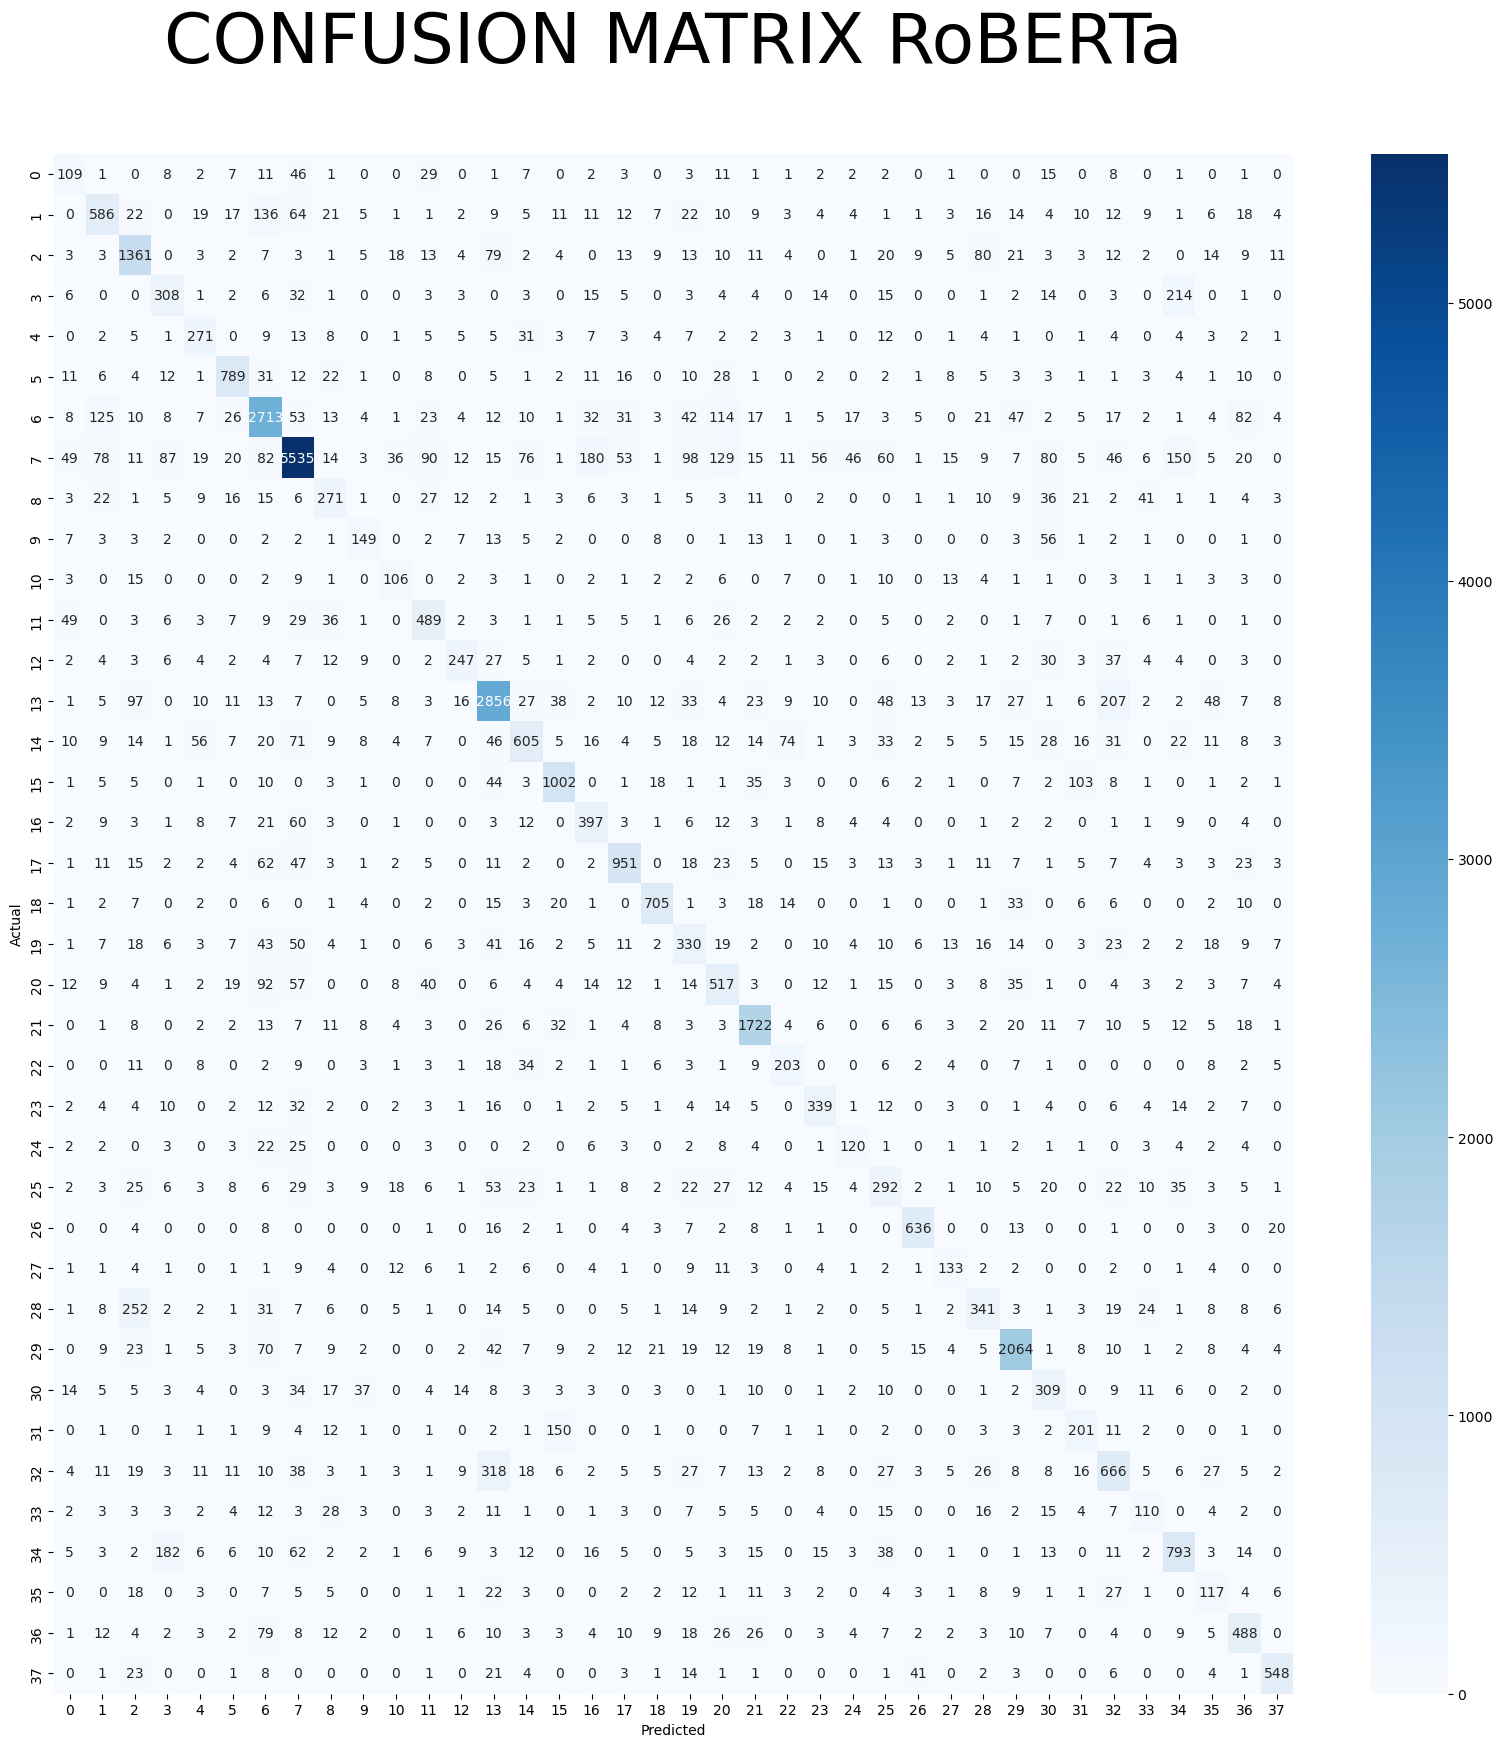

In [73]:
# MAX_LEN = 128
# TRAIN_BATCH_SIZE = 32
# VALID_BATCH_SIZE = 32
# EPOCHS = 3
# LEARNING_RATE = 2e-5
conf_mat = metrics.confusion_matrix(test_labels, y_pred)
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX RoBERTa\n", size=50)

In [74]:
from sklearn import metrics
print(metrics.classification_report(test_labels, y_pred))

              precision    recall  f1-score   support

           0       0.35      0.40      0.37       275
           1       0.62      0.54      0.58      1080
           2       0.68      0.77      0.72      1758
           3       0.46      0.47      0.46       660
           5       0.57      0.64      0.61       421
           6       0.80      0.78      0.79      1015
           7       0.75      0.78      0.77      3473
           8       0.87      0.78      0.82      7121
           9       0.50      0.49      0.50       555
          10       0.56      0.52      0.54       289
          11       0.46      0.52      0.49       203
          12       0.61      0.69      0.65       712
          13       0.67      0.56      0.61       441
          14       0.76      0.80      0.78      3589
          15       0.64      0.51      0.56      1198
          17       0.77      0.79      0.78      1268
          18       0.53      0.67      0.59       589
          19       0.79    